# MLE - Exercise 2 - Comparative Experimentation
## Andreas Kocman (se19m024)

## Assignment
In this exercise, you shall experiment with a number of (simple) algorithms on several datasets. The aim is to get a feeling how well each of these algorithms works, and whether there are differences depending on the dataset.

The datasets are
* [Iris](https://archive.ics.uci.edu/ml/datasets/Iris), for Python, use http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html)
* [Handwritten digits](https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits), of which we only use the test set of 1797 instances; for Python, use http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html)
* If you are a group of three (see below): [Breast Cancer dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)); skip the ID field; in Python: http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html)

The classifiers you shall use are
* k-NN (with 3 different values for k)
* Naive Bayes
* Perceptron, and
* Decision Trees with 3 different parameter settings (e.g. some pre-pruning setting, different split criterion, ...)

For each dataset, you shall train and evaluate each classifier (with parameter variations), and then compute several evaluation metrics
* Effectiveness: Accuracy, and 1 more of your choice (precision, recall, F1, ...
* Efficiency: runtime for training & testing
* As evaluation set splitting technique, you shall use once the holdout method with 2/3 training and the rest for testing, and once cross validation with 5 folds.

You shall present these results in a tabular form, with one table for each dataset & splitting combination approach.

Iris/5-folds | Accuracy | Precision| Training time | Testing time
---|---|---|---|---|---
k-NN (3-NN) | .85 | .82 | 0.1 sec | 27 sec
Naive Bayes | .72 | .82 | 1 sec | 2 sec
Decision Tree | .92 | .76 | 5 sec | 2 sec
... | ... | ...| ... | ...

Then describe the results, and analyse e.g.:
* Which classifiers work best?
* Are there differences between the datasets?
* Are the differences in the efficiency measurements?
* How is the runtime changing with the different data sets?
* ...

You can solve this exercise alone, or in a group of two students. If you form a group, you need to extend your scope, by
* Adding a third dataset, namely breast cancer wisconsin
* For k-NN, using 5 different values for k instead of 3, and use both weighted and uniform distance (i.e. a total of 10 combinations); for Decision Trees, also add 3 more parameter variations
* Adding a third efficiency evaluation metric

## Deliverables
Your submission shall contain
* The textual report
* All code samples and
* All data sets (if not already included in your software package, e.g. Python)

## Sources used
* Scikit documentation
* https://simonhessner.de/why-are-precision-recall-and-f1-score-equal-when-using-micro-averaging-in-a-multi-class-problem/

In [1]:
#General Imports
import numpy as numpy
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
import pandas as pd
import time

#Data reporting
from IPython.display import display

#Global variables
randomState=24  # change the state with the numeric parts of your matrikelnummer; if you are in a group, use the sume of the numeric parts
                # se19m024
averagingApproach = 'macro'
scoring = ['accuracy', 'precision_macro', 'recall_macro']
zero_divisionApproach = 0
number_of_folds = 5

#Overall report
ml_approaches = ['k-NN', 'bayes', 'perceptron', 'decision tree']
resultColumns = ['dataset','approach','arguments','split','accuracy','precision','recall','time training', 'time testing']

#Helper funcitons
def parse_k_fold_results(results):
    return "m: " + str(numpy.average(results)) + " std: " + str(numpy.std(results)) # + " values: " + str(results)

def parse_k_fold_timings(results):
    return "total: " + str(numpy.sum(results)) + " values: " + str(results)


In [2]:
from sklearn import neighbors

knn_results = []
testvalues = [3,10,15]

# parameters for k-NN
n_neighbors = testvalues
for dataset in [('iris', datasets.load_iris()),('digits', datasets.load_digits())]:
    # Shuffle our input data
    data, target = shuffle(dataset[1].data, dataset[1].target, random_state=randomState)

    # Prepare a train/test set split
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.33, random_state=(randomState+1))

    for n in n_neighbors:
        # train the k-NN
        classifier = neighbors.KNeighborsClassifier(n)
        classifier.random_state = randomState
        start_time_train = time.time()
        classifier.fit(X_train, y_train)
        end_time_train = time.time()

        # predict the test set on our trained classifier
        start_time_test = time.time()
        y_test_predicted = classifier.predict(X_test)
        end_time_test = time.time()

        # Compute metrics for holdout
        acc = metrics.accuracy_score(y_test, y_test_predicted)
        recall=metrics.recall_score(y_test, y_test_predicted, average=averagingApproach, zero_division=zero_divisionApproach)
        precision = metrics.precision_score(y_test, y_test_predicted, average=averagingApproach, zero_division=zero_divisionApproach)

        result = pd.Series({
            'dataset': dataset[0],
            'approach':'kNN',
            'arguments': 'n=' + str(n),
            'split': 'holdout',
            'accuracy':acc,
            'precision':precision,
            'recall':recall,
            'time training':end_time_train-start_time_train,
            'time testing':end_time_test-start_time_test
        })
        knn_results.append(result)

        # Compute metrics for k fold
        scores = cross_validate(classifier, data, target,
                                scoring = scoring,
                                cv = number_of_folds,
                                error_score = 0 )

        result = pd.Series({
            'dataset': dataset[0],
            'approach':'kNN',
            'arguments': 'n=' + str(n),
            'split': 'k-fold',
            'accuracy': parse_k_fold_results(scores.get('test_accuracy')),
            'precision': parse_k_fold_results(scores.get('test_precision_macro')),
            'recall':parse_k_fold_results(scores.get('test_recall_macro')),
            'time training':parse_k_fold_timings(scores.get('fit_time')),
            'time testing':parse_k_fold_timings(scores.get('score_time'))
        })
        knn_results.append(result)

knn_results_df = pd.DataFrame(knn_results)

### Iris
The results below show extremely high accuracy for kNN both with N values of 3, 10 and 15.

In [3]:
display(knn_results_df[(knn_results_df['dataset']=='iris') & (knn_results_df['split']=='holdout')])
display(knn_results_df[(knn_results_df['dataset']=='iris') & (knn_results_df['split']=='k-fold')])

,dataset,approach,arguments,split,accuracy,precision,recall,time training,time testing
0,iris,kNN,n=3,holdout,0.94,0.941176,0.952381,0,0.0029912
2,iris,kNN,n=10,holdout,0.92,0.925926,0.936508,0.00100708,0.00198483
4,iris,kNN,n=15,holdout,0.92,0.925926,0.936508,0.000997543,0.00199461


,dataset,approach,arguments,split,accuracy,precision,recall,time training,time testing
1,iris,kNN,n=3,k-fold,m: 0.9600000000000002 std: 0.024944382578492935,m: 0.9612121212121212 std: 0.02530983396099532,m: 0.96 std: 0.024944382578492984,total: 0.0029926300048828125 values: [0.000997...,total: 0.013962507247924805 values: [0.0029921...
3,iris,kNN,n=10,k-fold,m: 0.9733333333333334 std: 0.05333333333333332,m: 0.975 std: 0.049999999999999996,m: 0.9733333333333334 std: 0.053333333333333365,total: 0.0019941329956054688 values: [0. ...,total: 0.012965917587280273 values: [0.0029921...
5,iris,kNN,n=15,k-fold,m: 0.9733333333333334 std: 0.038873012632301994,m: 0.9744107744107744 std: 0.037890383559960134,m: 0.9733333333333334 std: 0.038873012632301994,total: 0.0019826889038085938 values: [0.000985...,total: 0.014960050582885742 values: [0.0029919...


### Handwritten Numbers

In [4]:
display(knn_results_df[(knn_results_df['dataset']=='digits') & (knn_results_df['split']=='holdout')])
display(knn_results_df[(knn_results_df['dataset']=='digits') & (knn_results_df['split']=='k-fold')])

,dataset,approach,arguments,split,accuracy,precision,recall,time training,time testing
6,digits,kNN,n=3,holdout,0.991582,0.99161,0.991301,0.0179558,0.0987611
8,digits,kNN,n=10,holdout,0.976431,0.976702,0.976281,0.017952,0.102726
10,digits,kNN,n=15,holdout,0.969697,0.969727,0.969164,0.0159569,0.092752


,dataset,approach,arguments,split,accuracy,precision,recall,time training,time testing
7,digits,kNN,n=3,k-fold,m: 0.9883209532652429 std: 0.007323832501573226,m: 0.9888385412595939 std: 0.00712739147876576,m: 0.9882972972972972 std: 0.007208664307978579,total: 0.10275459289550781 values: [0.02094388...,total: 0.3311154842376709 values: [0.06682134 ...
9,digits,kNN,n=10,k-fold,m: 0.9805277004023523 std: 0.007241231361602902,m: 0.9816830468409415 std: 0.00662931853158472,m: 0.9804048249930603 std: 0.00715395193374626,total: 0.10275840759277344 values: [0.02194023...,total: 0.337064266204834 values: [0.07081056 0...
11,digits,kNN,n=15,k-fold,m: 0.9771850820179511 std: 0.008687630086523833,m: 0.9786983227511679 std: 0.007575736564379982,m: 0.9770371716254068 std: 0.008674693211716449,total: 0.09970474243164062 values: [0.01994562...,total: 0.32419276237487793 values: [0.06382966...


##### Results:
The results indicate a best fit of a solution for n=9.

## Naive Bayes

In [5]:
from sklearn import naive_bayes

bayes_results = []

for dataset in [('iris', datasets.load_iris()),('digits', datasets.load_digits())]:
    # Shuffle our input data
    data, target = shuffle(dataset[1].data, dataset[1].target, random_state=randomState)

    # Prepare a train/test set split
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.33, random_state=(randomState+1))

    # train the bayes model
    classifier = naive_bayes.GaussianNB()
    classifier.random_state = randomState
    start_time_train = time.time()
    classifier.fit(X_train, y_train)
    end_time_train = time.time()

    # predict the test set on our trained classifier
    start_time_test = time.time()
    y_test_predicted = classifier.predict(X_test)
    end_time_test = time.time()

    # Compute metrics for holdout
    acc = metrics.accuracy_score(y_test, y_test_predicted)
    recall=metrics.recall_score(y_test, y_test_predicted, average=averagingApproach, zero_division=zero_divisionApproach)
    precision = metrics.precision_score(y_test, y_test_predicted, average=averagingApproach, zero_division=zero_divisionApproach)

    result = pd.Series({
        'dataset': dataset[0],
        'approach':'bayes',
        'arguments': 'none',
        'split': 'holdout',
        'accuracy':acc,
        'precision':precision,
        'recall':recall,
        'time training':end_time_train-start_time_train,
        'time testing':end_time_test-start_time_test
    })
    bayes_results.append(result)

    # Compute metrics for k fold
    scores = cross_validate(classifier, data, target,
                            scoring = scoring,
                            cv = number_of_folds,
                            error_score = 0)

    result = pd.Series({
        'dataset': dataset[0],
        'approach': 'bayes',
        'arguments': 'none',
        'split': 'k-fold',
        'accuracy': parse_k_fold_results(scores.get('test_accuracy')),
        'precision': parse_k_fold_results(scores.get('test_precision_macro')),
        'recall':parse_k_fold_results(scores.get('test_recall_macro')),
        'time training':parse_k_fold_timings(scores.get('fit_time')),
        'time testing':parse_k_fold_timings(scores.get('score_time'))
    })
    bayes_results.append(result)

bayes_results_df = pd.DataFrame(bayes_results)


### Iris

In [6]:
display(bayes_results_df[(bayes_results_df['dataset']=='iris') & (bayes_results_df['split']=='holdout')])
display(bayes_results_df[(bayes_results_df['dataset']=='iris') & (bayes_results_df['split']=='k-fold')])

,dataset,approach,arguments,split,accuracy,precision,recall,time training,time testing
0,iris,bayes,none,holdout,0.9,0.90305,0.912698,0.000997305,0


,dataset,approach,arguments,split,accuracy,precision,recall,time training,time testing
1,iris,bayes,none,k-fold,m: 0.9533333333333334 std: 0.03399346342395189,m: 0.9550168350168351 std: 0.03375719358407477,m: 0.9533333333333334 std: 0.0339934634239519,total: 0.0029859542846679688 values: [0.000996...,total: 0.005992412567138672 values: [0.0009999...


### Handwritten Numbers

In [7]:
display(bayes_results_df[(bayes_results_df['dataset']=='digits') & (bayes_results_df['split']=='holdout')])
display(bayes_results_df[(bayes_results_df['dataset']=='digits') & (bayes_results_df['split']=='k-fold')])

,dataset,approach,arguments,split,accuracy,precision,recall,time training,time testing
2,digits,bayes,none,holdout,0.833333,0.850641,0.833908,0.00199437,0.0019691


,dataset,approach,arguments,split,accuracy,precision,recall,time training,time testing
3,digits,bayes,none,k-fold,m: 0.8324945837202105 std: 0.009286635323422067,m: 0.8598088622118409 std: 0.015147678383072103,m: 0.8325454614278144 std: 0.009764788694682724,total: 0.01199197769165039 values: [0.00199556...,total: 0.01297307014465332 values: [0.00299144...


##### Results:
* Analysis using Bayes on the *Iris* dataset show good values for accuracy, precision and recall with extremely low training and testing time.
* Analysis using Bayes on the *Digit Dataset* show still good values for accuracy, precision and recall with extremely low training and testing time.

However, compared to k NN, the results for this data set are significantly lower for Bayes. While this was similar for the Iris dataset, with lower accuracy for bayes than for the k-nn, the difference was not similarly strong.


## Perceptron

In [8]:
from sklearn import linear_model

perceptron_results = []

for dataset in [('iris', datasets.load_iris()),('digits', datasets.load_digits())]:
    # Shuffle our input data
    data, target = shuffle(dataset[1].data, dataset[1].target, random_state=randomState)

    # Prepare a train/test set split
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.33, random_state=(randomState+1))

    # train the bayes model
    classifier = linear_model.Perceptron()
    classifier.random_state = randomState
    start_time_train = time.time()
    classifier.fit(X_train, y_train)
    end_time_train = time.time()

    # predict the test set on our trained classifier
    start_time_test = time.time()
    y_test_predicted = classifier.predict(X_test)
    end_time_test = time.time()

    # Compute metrics for holdout
    acc = metrics.accuracy_score(y_test, y_test_predicted)
    recall=metrics.recall_score(y_test, y_test_predicted, average=averagingApproach, zero_division=zero_divisionApproach)
    precision = metrics.precision_score(y_test, y_test_predicted, average=averagingApproach, zero_division=zero_divisionApproach)

    result = pd.Series({
        'dataset': dataset[0],
        'approach':'perceptron',
        'arguments': 'none',
        'split': 'holdout',
        'accuracy':acc,
        'precision':precision,
        'recall':recall,
        'time training':end_time_train-start_time_train,
        'time testing':end_time_test-start_time_test
    })
    perceptron_results.append(result)

    # Compute metrics for k fold
    scores = cross_validate(classifier, data, target,
                            scoring = scoring,
                            cv = number_of_folds,
                            error_score = 0)

    result = pd.Series({
        'dataset': dataset[0],
        'approach': 'perceptron',
        'arguments': 'none',
        'split': 'k-fold',
        'accuracy': parse_k_fold_results(scores.get('test_accuracy')),
        'precision': parse_k_fold_results(scores.get('test_precision_macro')),
        'recall':parse_k_fold_results(scores.get('test_recall_macro')),
        'time training':parse_k_fold_timings(scores.get('fit_time')),
        'time testing':parse_k_fold_timings(scores.get('score_time'))
    })
    perceptron_results.append(result)

perceptron_results_df = pd.DataFrame(perceptron_results)


f:\informatik\tw_mle_exercise2\venv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
f:\informatik\tw_mle_exercise2\venv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Iris

In [9]:
display(perceptron_results_df[(perceptron_results_df['dataset']=='iris') & (perceptron_results_df['split']=='holdout')])
display(perceptron_results_df[(perceptron_results_df['dataset']=='iris') & (perceptron_results_df['split']=='k-fold')])

,dataset,approach,arguments,split,accuracy,precision,recall,time training,time testing
0,iris,perceptron,none,holdout,0.34,0.432624,0.4,0.00202298,0


,dataset,approach,arguments,split,accuracy,precision,recall,time training,time testing
1,iris,perceptron,none,k-fold,m: 0.74 std: 0.10413666234542207,m: 0.6742889463477699 std: 0.19998100699035673,m: 0.74 std: 0.10413666234542203,total: 0.009000301361083984 values: [0.0019946...,total: 0.008951425552368164 values: [0.0029592...


### Handwritten Numbers

In [10]:
display(perceptron_results_df[(perceptron_results_df['dataset']=='digits') & (perceptron_results_df['split']=='holdout')])
display(perceptron_results_df[(perceptron_results_df['dataset']=='digits') & (perceptron_results_df['split']=='k-fold')])

,dataset,approach,arguments,split,accuracy,precision,recall,time training,time testing
2,digits,perceptron,none,holdout,0.939394,0.94141,0.93962,0.0239067,0


,dataset,approach,arguments,split,accuracy,precision,recall,time training,time testing
3,digits,perceptron,none,k-fold,m: 0.9410229031259671 std: 0.015849668296257387,m: 0.9472330796425998 std: 0.01371753706347739,m: 0.9410189264895147 std: 0.015777826142176866,total: 0.13663363456726074 values: [0.02892208...,total: 0.00698399543762207 values: [0.00099802...


##### Results:
* Analysis using the Perceptron approach on the *Iris dataset* show low values for accuracy, precision and recall with extremely low training and testing time.
Compared to both Bayes and k NN, the results for this data set are significantly lower.
* Analysis using the Perceptron approach on the *Digits dataset* show very good values for accuracy, precision and recall with extremely low training and testing time.
Both Bayes and kNN yielded comparable results. The difference between the Digit and Iris dataset show Perceptron's high susceptibility to the data it is used for.

## Decision Tree

In [11]:
from sklearn import tree
import itertools

decision_tree_results = []

# Parameters for the decision tree
max_depth_arguments = [5,10,15]
min_samples_leaf_arguments = [2,20,40]
splitting_approaches_arguments = ['random', 'best']
argumentTuples = list(itertools.product(max_depth_arguments,
                                        min_samples_leaf_arguments,
                                        splitting_approaches_arguments))

for dataset in [('iris', datasets.load_iris()),('digits', datasets.load_digits())]:
    # Shuffle our input data
    data, target = shuffle(dataset[1].data, dataset[1].target, random_state=randomState)

    # Prepare a train/test set split
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.33, random_state=(randomState+1))

    for argumentTuple in argumentTuples:
        max_depth = argumentTuple[0]
        min_samples_leaf = argumentTuple[1]
        splitting_approach = argumentTuple[2]

        # train the k-NN
        classifier = tree.DecisionTreeClassifier(criterion = 'gini',
                                                 max_depth = max_depth,
                                                 min_samples_leaf = min_samples_leaf,
                                                 splitter = splitting_approach)

        classifier.random_state = randomState
        start_time_train = time.time()
        classifier.fit(X_train, y_train)
        end_time_train = time.time()

        # predict the test set on our trained classifier
        start_time_test = time.time()
        y_test_predicted = classifier.predict(X_test)
        end_time_test = time.time()

        # Compute metrics for holdout
        acc = metrics.accuracy_score(y_test, y_test_predicted)
        recall=metrics.recall_score(y_test, y_test_predicted, average=averagingApproach, zero_division=zero_divisionApproach)
        precision = metrics.precision_score(y_test, y_test_predicted, average=averagingApproach, zero_division=zero_divisionApproach)

        result = pd.Series({
            'dataset': dataset[0],
            'approach':'Decision Tree Classifier',
            'arguments': argumentTuple,
            'split': 'holdout',
            'accuracy':acc,
            'precision':precision,
            'recall':recall,
            'time training':end_time_train-start_time_train,
            'time testing':end_time_test-start_time_test
        })
        decision_tree_results.append(result)

        # Compute metrics for k fold
        scores = cross_validate(classifier, data, target,
                                scoring = scoring,
                                cv = number_of_folds,
                                error_score = 0)

        result = pd.Series({
            'dataset': dataset[0],
            'approach':'Decision Tree Classifier',
            'arguments': argumentTuple,
            'split': 'k-fold',
            'accuracy': parse_k_fold_results(scores.get('test_accuracy')),
            'precision': parse_k_fold_results(scores.get('test_precision_macro')),
            'recall':parse_k_fold_results(scores.get('test_recall_macro')),
            'time training':parse_k_fold_timings(scores.get('fit_time')),
            'time testing':parse_k_fold_timings(scores.get('score_time'))
        })
        decision_tree_results.append(result)

decision_tree_results_df = pd.DataFrame(decision_tree_results)


f:\informatik\tw_mle_exercise2\venv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
f:\informatik\tw_mle_exercise2\venv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
f:\informatik\tw_mle_exercise2\venv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
f:\informatik\tw_mle_exercise2\venv\lib\site-packages\sklearn

### Iris

,dataset,approach,arguments,split,accuracy,precision,recall,time training,time testing
0,iris,Decision Tree Classifier,"(5, 2, random)",holdout,0.88,0.890278,0.865079,0.00099659,0
2,iris,Decision Tree Classifier,"(5, 2, best)",holdout,0.9,0.90305,0.912698,0,0
4,iris,Decision Tree Classifier,"(5, 20, random)",holdout,0.48,0.45,0.555556,0,0
6,iris,Decision Tree Classifier,"(5, 20, best)",holdout,0.9,0.90305,0.912698,0,0
8,iris,Decision Tree Classifier,"(5, 40, random)",holdout,0.28,0.0933333,0.333333,0.000997543,0
10,iris,Decision Tree Classifier,"(5, 40, best)",holdout,0.54,0.41533,0.619048,0.000997305,0
12,iris,Decision Tree Classifier,"(10, 2, random)",holdout,0.9,0.894956,0.904762,0.000997543,0
14,iris,Decision Tree Classifier,"(10, 2, best)",holdout,0.9,0.90305,0.912698,0,0.000997305
16,iris,Decision Tree Classifier,"(10, 20, random)",holdout,0.48,0.45,0.555556,0.000997543,0
18,iris,Decision Tree Classifier,"(10, 20, best)",holdout,0.9,0.90305,0.912698,0.000995874,0


,dataset,approach,arguments,split,accuracy,precision,recall,time training,time testing
1,iris,Decision Tree Classifier,"(5, 2, random)",k-fold,m: 0.8800000000000001 std: 0.05416025603090639,m: 0.9151709401709403 std: 0.02856862378351845,m: 0.8799999999999999 std: 0.05416025603090637,total: 0.004986286163330078 values: [0.0009970...,total: 0.004987001419067383 values: [0.0009975...
3,iris,Decision Tree Classifier,"(5, 2, best)",k-fold,m: 0.9400000000000001 std: 0.04422166387140532,m: 0.9444949494949496 std: 0.04164152899506982,m: 0.9400000000000001 std: 0.044221663871405366,total: 0.005007743835449219 values: [0.0009973...,total: 0.0049974918365478516 values: [0.000997...
5,iris,Decision Tree Classifier,"(5, 20, random)",k-fold,m: 0.5599999999999999 std: 0.024944382578492935,m: 0.47716293368467283 std: 0.004696804926703416,m: 0.5599999999999999 std: 0.024944382578492935,total: 0.002966165542602539 values: [0.0010004...,total: 0.007972002029418945 values: [0.0019595...
7,iris,Decision Tree Classifier,"(5, 20, best)",k-fold,m: 0.9266666666666667 std: 0.04422166387140532,m: 0.9332491582491583 std: 0.04255264892173636,m: 0.9266666666666665 std: 0.044221663871405345,total: 0.001994609832763672 values: [0.0009973...,total: 0.0069811344146728516 values: [0.000997...
9,iris,Decision Tree Classifier,"(5, 40, random)",k-fold,m: 0.3333333333333333 std: 0.0,m: 0.11111111111111112 std: 1.3877787807814457...,m: 0.3333333333333333 std: 0.0,total: 0.0020182132720947266 values: [0. ...,total: 0.007998228073120117 values: [0.0020265...
11,iris,Decision Tree Classifier,"(5, 40, best)",k-fold,m: 0.7666666666666666 std: 0.12292725943057185,m: 0.6693602693602694 std: 0.20784967494940076,m: 0.7666666666666666 std: 0.12292725943057183,total: 0.003008127212524414 values: [0. ...,total: 0.0069658756256103516 values: [0.002012...
13,iris,Decision Tree Classifier,"(10, 2, random)",k-fold,m: 0.9199999999999999 std: 0.04521553322083511,m: 0.9307840307840308 std: 0.03813348030226439,m: 0.9199999999999999 std: 0.0452155332208351,total: 0.000997304916381836 values: [0. ...,total: 0.005967140197753906 values: [0.0019621...
15,iris,Decision Tree Classifier,"(10, 2, best)",k-fold,m: 0.9400000000000001 std: 0.04422166387140532,m: 0.9444949494949496 std: 0.04164152899506982,m: 0.9400000000000001 std: 0.044221663871405366,total: 0.00399017333984375 values: [0. ...,total: 0.004956722259521484 values: [0.0009965...
17,iris,Decision Tree Classifier,"(10, 20, random)",k-fold,m: 0.5599999999999999 std: 0.024944382578492935,m: 0.47716293368467283 std: 0.004696804926703416,m: 0.5599999999999999 std: 0.024944382578492935,total: 0.0029053688049316406 values: [0.000910...,total: 0.009946107864379883 values: [0.0009987...
19,iris,Decision Tree Classifier,"(10, 20, best)",k-fold,m: 0.9266666666666667 std: 0.04422166387140532,m: 0.9332491582491583 std: 0.04255264892173636,m: 0.9266666666666665 std: 0.044221663871405345,total: 0.001962423324584961 values: [0. ...,total: 0.00900721549987793 values: [0.00202441...


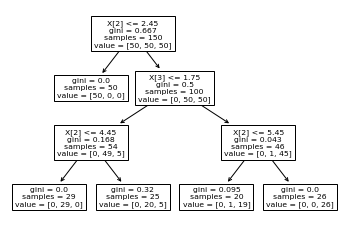

In [12]:
datasetIris = datasets.load_iris();
classifier = tree.DecisionTreeClassifier(criterion = 'gini',
                                         max_depth = 10,
                                         min_samples_leaf = 20,
                                         splitter = 'best')
tree.plot_tree(classifier.fit(datasetIris.data, datasetIris.target),max_depth=5)
display(decision_tree_results_df[(decision_tree_results_df['dataset']=='iris') & (decision_tree_results_df['split']=='holdout')])
display(decision_tree_results_df[(decision_tree_results_df['dataset']=='iris') & (decision_tree_results_df['split']=='k-fold')])

### Handwritten Numbers

,dataset,approach,arguments,split,accuracy,precision,recall,time training,time testing
36,digits,Decision Tree Classifier,"(5, 2, random)",holdout,0.673401,0.717454,0.677103,0.00298977,0.000997066
38,digits,Decision Tree Classifier,"(5, 2, best)",holdout,0.6633,0.746121,0.663671,0.010972,0.000997543
40,digits,Decision Tree Classifier,"(5, 20, random)",holdout,0.643098,0.637573,0.641345,0.00299096,0
42,digits,Decision Tree Classifier,"(5, 20, best)",holdout,0.658249,0.720075,0.657125,0.00797844,0
44,digits,Decision Tree Classifier,"(5, 40, random)",holdout,0.624579,0.595066,0.623683,0.00297952,0
46,digits,Decision Tree Classifier,"(5, 40, best)",holdout,0.607744,0.59806,0.604756,0.0069809,0.000997782
48,digits,Decision Tree Classifier,"(10, 2, random)",holdout,0.821549,0.827151,0.822762,0.00501871,0
50,digits,Decision Tree Classifier,"(10, 2, best)",holdout,0.833333,0.84214,0.836688,0.0139635,0
52,digits,Decision Tree Classifier,"(10, 20, random)",holdout,0.742424,0.749126,0.743035,0.00299191,0.000997782
54,digits,Decision Tree Classifier,"(10, 20, best)",holdout,0.794613,0.80054,0.797709,0.00900817,0.000998735


,dataset,approach,arguments,split,accuracy,precision,recall,time training,time testing
37,digits,Decision Tree Classifier,"(5, 2, random)",k-fold,m: 0.682799442896936 std: 0.0225789955736832,m: 0.717660567564935 std: 0.026132446284686445,m: 0.6822451106568753 std: 0.022306835943359964,total: 0.028920888900756836 values: [0.0049846...,total: 0.009973526000976562 values: [0.0019960...
39,digits,Decision Tree Classifier,"(5, 2, best)",k-fold,m: 0.6521990095945527 std: 0.029293764851288196,m: 0.7298174310895975 std: 0.01717008365700091,m: 0.6520541549953315 std: 0.028721061472361847,total: 0.06482982635498047 values: [0.01196933...,total: 0.00997304916381836 values: [0.00199485...
41,digits,Decision Tree Classifier,"(5, 20, random)",k-fold,m: 0.6750278551532034 std: 0.040755563742608684,m: 0.6950497115958991 std: 0.061857032803490745,m: 0.674860019683549 std: 0.04133979548873456,total: 0.021940946578979492 values: [0.0049874...,total: 0.009973526000976562 values: [0.0029909...
43,digits,Decision Tree Classifier,"(5, 20, best)",k-fold,m: 0.642189724543485 std: 0.026859596447899876,m: 0.703735266738326 std: 0.01501969790860612,m: 0.6420215509627274 std: 0.026807715646732715,total: 0.04886913299560547 values: [0.00997281...,total: 0.00997304916381836 values: [0.00199485...
45,digits,Decision Tree Classifier,"(5, 40, random)",k-fold,m: 0.6282559579077684 std: 0.04962782791262363,m: 0.6253692157304211 std: 0.05839129334704999,m: 0.6283112019582608 std: 0.050742761166004666,total: 0.01900506019592285 values: [0.00398517...,total: 0.008919239044189453 values: [0.0019950...
47,digits,Decision Tree Classifier,"(5, 40, best)",k-fold,m: 0.6271649644073042 std: 0.022340010709646117,m: 0.6660513441822741 std: 0.02980445680574132,m: 0.6270297019708784 std: 0.022343553593636677,total: 0.04684734344482422 values: [0.00897574...,total: 0.009006738662719727 values: [0.0019977...
49,digits,Decision Tree Classifier,"(10, 2, random)",k-fold,m: 0.8492169606932837 std: 0.024701250873822116,m: 0.8535964619626707 std: 0.024247845316340284,m: 0.848803896333308 std: 0.024983989383474584,total: 0.03191232681274414 values: [0.00694966...,total: 0.007977724075317383 values: [0.0009980...
51,digits,Decision Tree Classifier,"(10, 2, best)",k-fold,m: 0.8497415660786135 std: 0.016289255420700997,m: 0.8559045305923447 std: 0.016949978229067093,m: 0.8496446109975521 std: 0.016132101050840803,total: 0.07774758338928223 values: [0.01592493...,total: 0.008978128433227539 values: [0.0019953...
53,digits,Decision Tree Classifier,"(10, 20, random)",k-fold,m: 0.7334292788610337 std: 0.020905478914734647,m: 0.7394966477817702 std: 0.02134785363906439,m: 0.7331400055517703 std: 0.02089872408546371,total: 0.022938013076782227 values: [0.0039889...,total: 0.008977651596069336 values: [0.0019950...
55,digits,Decision Tree Classifier,"(10, 20, best)",k-fold,m: 0.7879712163416899 std: 0.01638106112774851,m: 0.7966323249656977 std: 0.019183878519583475,m: 0.7882291114644057 std: 0.0162673398542481,total: 0.06482529640197754 values: [0.01296425...,total: 0.00897359848022461 values: [0.00099754...


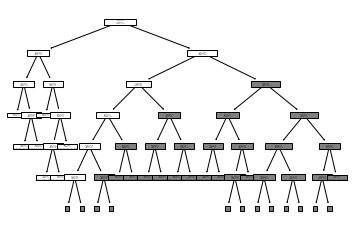

In [13]:
datasetDigits = datasets.load_digits();
classifier = tree.DecisionTreeClassifier(criterion = 'gini',
                                         max_depth = 10,
                                         min_samples_leaf = 20,
                                         splitter = 'best')
tree.plot_tree(classifier.fit(datasetDigits.data, datasetDigits.target),max_depth=5)

display(decision_tree_results_df[(decision_tree_results_df['dataset']=='digits') & (decision_tree_results_df['split']=='holdout')])
display(decision_tree_results_df[(decision_tree_results_df['dataset']=='digits') & (decision_tree_results_df['split']=='k-fold')])

##### Results:
* Random and Best Splitting Approach for the Decision Tree on both the Iris and Digits Dataset:
The overall results indicate that the "best" splitting parameter yields by far superior results compared to the "random" approach.
* Min Sample Leaf Values: Additional analyses of the results from the previous step show that there is overfitting after a max depth of 2 with only limited benefits of additional splits.
To counteract the creation of additional nodes, min_samples_leaf was added as parameter for an extensive high maximum depth (30).
* Analysis using the Decision Tree approach on the Digits Dataset show a high relevance of the defined max tree depth for accuracy, precision and recall with extremely low training and testing time. For a max depth of 7, the resulting tree yields good results with limited overfitting. Potential subsequent pruning could further reduce overfitting.

# Overall Results

In [14]:
overall_results = knn_results + bayes_results + perceptron_results + decision_tree_results
overall_results_df = pd.DataFrame(overall_results)

## Iris Dataset
### Holdout

In [15]:
display(overall_results_df[
            (overall_results_df['dataset']=='iris') &
            (overall_results_df['split']=='holdout')])

,dataset,approach,arguments,split,accuracy,precision,recall,time training,time testing
0,iris,kNN,n=3,holdout,0.94,0.941176,0.952381,0,0.0029912
2,iris,kNN,n=10,holdout,0.92,0.925926,0.936508,0.00100708,0.00198483
4,iris,kNN,n=15,holdout,0.92,0.925926,0.936508,0.000997543,0.00199461
12,iris,bayes,none,holdout,0.9,0.90305,0.912698,0.000997305,0
16,iris,perceptron,none,holdout,0.34,0.432624,0.4,0.00202298,0
20,iris,Decision Tree Classifier,"(5, 2, random)",holdout,0.88,0.890278,0.865079,0.00099659,0
22,iris,Decision Tree Classifier,"(5, 2, best)",holdout,0.9,0.90305,0.912698,0,0
24,iris,Decision Tree Classifier,"(5, 20, random)",holdout,0.48,0.45,0.555556,0,0
26,iris,Decision Tree Classifier,"(5, 20, best)",holdout,0.9,0.90305,0.912698,0,0
28,iris,Decision Tree Classifier,"(5, 40, random)",holdout,0.28,0.0933333,0.333333,0.000997543,0


### K Fold

In [16]:
display(overall_results_df[
            (overall_results_df['dataset']=='iris') &
            (overall_results_df['split']=='k-fold')])


,dataset,approach,arguments,split,accuracy,precision,recall,time training,time testing
1,iris,kNN,n=3,k-fold,m: 0.9600000000000002 std: 0.024944382578492935,m: 0.9612121212121212 std: 0.02530983396099532,m: 0.96 std: 0.024944382578492984,total: 0.0029926300048828125 values: [0.000997...,total: 0.013962507247924805 values: [0.0029921...
3,iris,kNN,n=10,k-fold,m: 0.9733333333333334 std: 0.05333333333333332,m: 0.975 std: 0.049999999999999996,m: 0.9733333333333334 std: 0.053333333333333365,total: 0.0019941329956054688 values: [0. ...,total: 0.012965917587280273 values: [0.0029921...
5,iris,kNN,n=15,k-fold,m: 0.9733333333333334 std: 0.038873012632301994,m: 0.9744107744107744 std: 0.037890383559960134,m: 0.9733333333333334 std: 0.038873012632301994,total: 0.0019826889038085938 values: [0.000985...,total: 0.014960050582885742 values: [0.0029919...
13,iris,bayes,none,k-fold,m: 0.9533333333333334 std: 0.03399346342395189,m: 0.9550168350168351 std: 0.03375719358407477,m: 0.9533333333333334 std: 0.0339934634239519,total: 0.0029859542846679688 values: [0.000996...,total: 0.005992412567138672 values: [0.0009999...
17,iris,perceptron,none,k-fold,m: 0.74 std: 0.10413666234542207,m: 0.6742889463477699 std: 0.19998100699035673,m: 0.74 std: 0.10413666234542203,total: 0.009000301361083984 values: [0.0019946...,total: 0.008951425552368164 values: [0.0029592...
21,iris,Decision Tree Classifier,"(5, 2, random)",k-fold,m: 0.8800000000000001 std: 0.05416025603090639,m: 0.9151709401709403 std: 0.02856862378351845,m: 0.8799999999999999 std: 0.05416025603090637,total: 0.004986286163330078 values: [0.0009970...,total: 0.004987001419067383 values: [0.0009975...
23,iris,Decision Tree Classifier,"(5, 2, best)",k-fold,m: 0.9400000000000001 std: 0.04422166387140532,m: 0.9444949494949496 std: 0.04164152899506982,m: 0.9400000000000001 std: 0.044221663871405366,total: 0.005007743835449219 values: [0.0009973...,total: 0.0049974918365478516 values: [0.000997...
25,iris,Decision Tree Classifier,"(5, 20, random)",k-fold,m: 0.5599999999999999 std: 0.024944382578492935,m: 0.47716293368467283 std: 0.004696804926703416,m: 0.5599999999999999 std: 0.024944382578492935,total: 0.002966165542602539 values: [0.0010004...,total: 0.007972002029418945 values: [0.0019595...
27,iris,Decision Tree Classifier,"(5, 20, best)",k-fold,m: 0.9266666666666667 std: 0.04422166387140532,m: 0.9332491582491583 std: 0.04255264892173636,m: 0.9266666666666665 std: 0.044221663871405345,total: 0.001994609832763672 values: [0.0009973...,total: 0.0069811344146728516 values: [0.000997...
29,iris,Decision Tree Classifier,"(5, 40, random)",k-fold,m: 0.3333333333333333 std: 0.0,m: 0.11111111111111112 std: 1.3877787807814457...,m: 0.3333333333333333 std: 0.0,total: 0.0020182132720947266 values: [0. ...,total: 0.007998228073120117 values: [0.0020265...


### Effectiveness
Despite the heterogenous approaches used, acccuracy, precision and recall were good across most approaches with the notable exception of the Perceptron.

The data set may hence be prone to ceiling effects for measuring effectiveness for such numerical categorization tasks.

### Efficiency
In the datasets used as well as in the approaches applied, the training and testing time measured were low to non-measurable.

Benchmarking with these limited differences across approaches would be too prone to additional confounding variables such as running background tasks and other effects not associated with the machine learning tasks.

## Handwritten Numbers Dataset
### Holdout

In [17]:
display(overall_results_df[
            (overall_results_df['dataset']=='digits') &
            (overall_results_df['split']=='holdout')])

,dataset,approach,arguments,split,accuracy,precision,recall,time training,time testing
6,digits,kNN,n=3,holdout,0.991582,0.99161,0.991301,0.0179558,0.0987611
8,digits,kNN,n=10,holdout,0.976431,0.976702,0.976281,0.017952,0.102726
10,digits,kNN,n=15,holdout,0.969697,0.969727,0.969164,0.0159569,0.092752
14,digits,bayes,none,holdout,0.833333,0.850641,0.833908,0.00199437,0.0019691
18,digits,perceptron,none,holdout,0.939394,0.94141,0.93962,0.0239067,0
56,digits,Decision Tree Classifier,"(5, 2, random)",holdout,0.673401,0.717454,0.677103,0.00298977,0.000997066
58,digits,Decision Tree Classifier,"(5, 2, best)",holdout,0.6633,0.746121,0.663671,0.010972,0.000997543
60,digits,Decision Tree Classifier,"(5, 20, random)",holdout,0.643098,0.637573,0.641345,0.00299096,0
62,digits,Decision Tree Classifier,"(5, 20, best)",holdout,0.658249,0.720075,0.657125,0.00797844,0
64,digits,Decision Tree Classifier,"(5, 40, random)",holdout,0.624579,0.595066,0.623683,0.00297952,0


### K Fold

In [18]:
display(overall_results_df[
            (overall_results_df['dataset']=='digits') &
            (overall_results_df['split']=='k-fold')])

,dataset,approach,arguments,split,accuracy,precision,recall,time training,time testing
7,digits,kNN,n=3,k-fold,m: 0.9883209532652429 std: 0.007323832501573226,m: 0.9888385412595939 std: 0.00712739147876576,m: 0.9882972972972972 std: 0.007208664307978579,total: 0.10275459289550781 values: [0.02094388...,total: 0.3311154842376709 values: [0.06682134 ...
9,digits,kNN,n=10,k-fold,m: 0.9805277004023523 std: 0.007241231361602902,m: 0.9816830468409415 std: 0.00662931853158472,m: 0.9804048249930603 std: 0.00715395193374626,total: 0.10275840759277344 values: [0.02194023...,total: 0.337064266204834 values: [0.07081056 0...
11,digits,kNN,n=15,k-fold,m: 0.9771850820179511 std: 0.008687630086523833,m: 0.9786983227511679 std: 0.007575736564379982,m: 0.9770371716254068 std: 0.008674693211716449,total: 0.09970474243164062 values: [0.01994562...,total: 0.32419276237487793 values: [0.06382966...
15,digits,bayes,none,k-fold,m: 0.8324945837202105 std: 0.009286635323422067,m: 0.8598088622118409 std: 0.015147678383072103,m: 0.8325454614278144 std: 0.009764788694682724,total: 0.01199197769165039 values: [0.00199556...,total: 0.01297307014465332 values: [0.00299144...
19,digits,perceptron,none,k-fold,m: 0.9410229031259671 std: 0.015849668296257387,m: 0.9472330796425998 std: 0.01371753706347739,m: 0.9410189264895147 std: 0.015777826142176866,total: 0.13663363456726074 values: [0.02892208...,total: 0.00698399543762207 values: [0.00099802...
57,digits,Decision Tree Classifier,"(5, 2, random)",k-fold,m: 0.682799442896936 std: 0.0225789955736832,m: 0.717660567564935 std: 0.026132446284686445,m: 0.6822451106568753 std: 0.022306835943359964,total: 0.028920888900756836 values: [0.0049846...,total: 0.009973526000976562 values: [0.0019960...
59,digits,Decision Tree Classifier,"(5, 2, best)",k-fold,m: 0.6521990095945527 std: 0.029293764851288196,m: 0.7298174310895975 std: 0.01717008365700091,m: 0.6520541549953315 std: 0.028721061472361847,total: 0.06482982635498047 values: [0.01196933...,total: 0.00997304916381836 values: [0.00199485...
61,digits,Decision Tree Classifier,"(5, 20, random)",k-fold,m: 0.6750278551532034 std: 0.040755563742608684,m: 0.6950497115958991 std: 0.061857032803490745,m: 0.674860019683549 std: 0.04133979548873456,total: 0.021940946578979492 values: [0.0049874...,total: 0.009973526000976562 values: [0.0029909...
63,digits,Decision Tree Classifier,"(5, 20, best)",k-fold,m: 0.642189724543485 std: 0.026859596447899876,m: 0.703735266738326 std: 0.01501969790860612,m: 0.6420215509627274 std: 0.026807715646732715,total: 0.04886913299560547 values: [0.00997281...,total: 0.00997304916381836 values: [0.00199485...
65,digits,Decision Tree Classifier,"(5, 40, random)",k-fold,m: 0.6282559579077684 std: 0.04962782791262363,m: 0.6253692157304211 std: 0.05839129334704999,m: 0.6283112019582608 std: 0.050742761166004666,total: 0.01900506019592285 values: [0.00398517...,total: 0.008919239044189453 values: [0.0019950...


### Effectiveness
Again,  acccuracy, precision and recall were good across all approaches.
In this specific case, also the perceptron yielded notable better results.

Again, the data set may  be prone to ceiling effects for measuring effectiveness for such image recognition tasks.

### Efficiency
Similar to the Iris dataset the training and testing time measured were low to non-measurable.

Benchmarking with these limited differences across approaches would be too prone to additional confounding variables such as running background tasks and other effects not associated with the machine learning tasks.
Larger and more complex datasets would yield more meaningful results in terms of efficiency.